In [220]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [221]:
import numpy as np
import pandas as pd

In [222]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [223]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [224]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [225]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [226]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [227]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [238]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [229]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [230]:
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [231]:
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [269]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.id.desc()).limit(1).all()
last_date=dt.datetime.strptime(last_date[0][0], '%Y-%m-%d')
year_ago = last_date - dt.timedelta(days=366)
print(last_date)
print(year_ago)

# Perform a query to retrieve the data and precipitation scores
precipitation = session.query(Measurement.date,Measurement.prcp).\
filter(Measurement.date > year_ago).all()
precipitation




2017-08-23 00:00:00
2016-08-22 00:00:00


[('2016-08-23', 0.0),
 ('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0),
 ('2016-08-28', 0.01),
 ('2016-08-29', 0.0),
 ('2016-08-30', 0.0),
 ('2016-08-31', 0.13),
 ('2016-09-01', 0.0),
 ('2016-09-02', 0.0),
 ('2016-09-03', 0.0),
 ('2016-09-04', 0.03),
 ('2016-09-05', None),
 ('2016-09-06', None),
 ('2016-09-07', 0.05),
 ('2016-09-08', 0.0),
 ('2016-09-09', 0.03),
 ('2016-09-10', 0.0),
 ('2016-09-11', 0.05),
 ('2016-09-12', 0.0),
 ('2016-09-13', 0.02),
 ('2016-09-14', 1.32),
 ('2016-09-15', 0.42),
 ('2016-09-16', 0.06),
 ('2016-09-17', 0.05),
 ('2016-09-18', 0.0),
 ('2016-09-19', 0.0),
 ('2016-09-20', 0.0),
 ('2016-09-21', 0.0),
 ('2016-09-22', 0.02),
 ('2016-09-23', 0.0),
 ('2016-09-24', 0.0),
 ('2016-09-25', 0.0),
 ('2016-09-26', 0.06),
 ('2016-09-27', 0.02),
 ('2016-09-28', 0.0),
 ('2016-09-29', 0.0),
 ('2016-09-30', 0.0),
 ('2016-10-01', 0.0),
 ('2016-10-02', 0.0),
 ('2016-10-03', 0.0),
 ('2016-10-04', 0.0),
 ('2016-10-05', 0.0),
 ('2016-10-06'

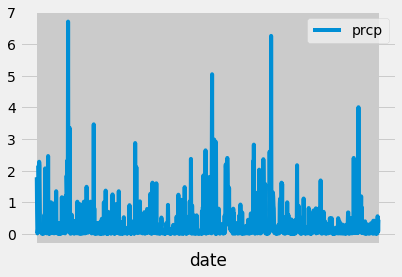

In [306]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(precipitation)
drop_zeros=precipitation_df.index[precipitation_df["prcp"] == 0].tolist()
precipitation_df_dropped=precipitation_df.drop(precipitation_df.index[drop_zeros])
precipitation_df_dropped.dropna(inplace=True)

# Sort the dataframe by date
precipitation_df_dropped.sort_values('date',inplace=True)
precipitation_df_dropped.set_index('date',inplace=True)
precipitation_grouped=precipitation_df_dropped.groupby('date').mean()
 
# Use Pandas Plotting with Matplotlib to plot the data
fig=precipitation_df_dropped.plot(kind='line')
x=fig.set_xticks(list(range(len(precipitation_df_dropped.index))))

![precipitation](Images/precipitation.png)

In [234]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [235]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Station.station).group_by(Station.station).count()
print(stations)

9


In [248]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations_agg = session.query(Measurement.station,func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
stations_agg

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [256]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temp_range = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
filter(Measurement.station == 'USC00519281').all()
temp_range

[(54.0, 85.0, 71.66378066378067)]

In [264]:
# Choose the station with the highest number of temperature observations.
station_temps=session.query(Measurement.station,func.count(Measurement.tobs)).\
group_by(Measurement.station).filter(Measurement.tobs>0, Measurement.tobs != 'NaN').\
order_by(func.count(Measurement.tobs).desc()).all()
station_temps

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

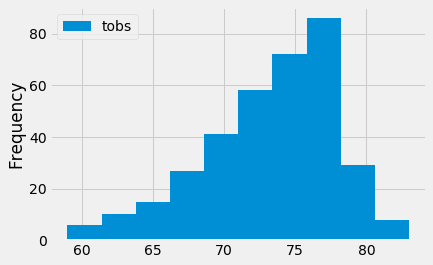

In [266]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temps = session.query(Measurement.tobs).\
filter(Measurement.date > year_ago).filter(Measurement.station == station_temps[0][0]).all()
temps_df = pd.DataFrame(temps)
temps_df.plot(kind='hist')

![precipitation](Images/station-histogram.png)

In [274]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [319]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date='2019-07-01'
end_date='2019-07-16'
start_date_dt=dt.datetime.strptime(start_date, '%Y-%m-%d')
end_date_dt=dt.datetime.strptime(end_date, '%Y-%m-%d')
year_ago_start = start_date_dt - dt.timedelta(days=2*365)
year_ago_end = end_date_dt - dt.timedelta(days=2*365)
print(f"last date in data set = {last_date.strftime('%Y-%m-%d')}")
print(f"start of trip = {start_date}")
print(f"end of trip = {end_date}")
trip_temps=calc_temps(year_ago_start.strftime('%Y-%m-%d'),year_ago_end.strftime('%Y-%m-%d'))
print(f"Temperatures two years before trip start: {trip_temps}")

last date in data set = 2017-08-23
start of trip = 2019-07-01
end of trip = 2019-07-16
Temperatures two years before trip start: [(69.0, 78.25510204081633, 87.0)]


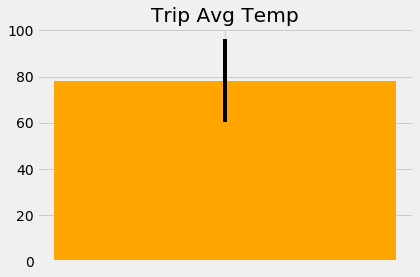

In [354]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
avg_trip_temp=trip_temps[0][1]
min_trip_temp=trip_temps[0][0]
max_trip_temp=trip_temps[0][2]

fig=plt.bar(0,avg_trip_temp, yerr = max_trip_temp-min_trip_temp, tick_label="", \
    color='orange',width=0.1,align='center')
title=plt.title('Trip Avg Temp')

In [360]:
# Calculate the total amount of rainfall per weather station for your trip dates 
#using the previous year's matching dates.
# Sort this in descending order by precipitation 
#amount and list the station, name, latitude, longitude, and elevation

rainfall = session.query(Station.station, func.sum(Measurement.prcp),Station.name,\
                         Station.elevation,Station.latitude,Station.longitude)\
.filter(Measurement.station == Station.station)\
.filter(Measurement.date >= year_ago_start)\
.filter(Measurement.date <= year_ago_end)\
.group_by(Station.station)\
.order_by(func.sum(Measurement.prcp).desc()).all()

rainfall

[('USC00516128',
  3.2700000000000005,
  'MANOA LYON ARBO 785.2, HI US',
  152.4,
  21.3331,
  -157.8025),
 ('USC00519281',
  1.6600000000000001,
  'WAIHEE 837.5, HI US',
  32.9,
  21.45167,
  -157.84888999999998),
 ('USC00513117',
  0.8400000000000001,
  'KANEOHE 838.1, HI US',
  14.6,
  21.4234,
  -157.8015),
 ('USC00514830',
  0.51,
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  7.0,
  21.5213,
  -157.8374),
 ('USC00519397', 0.21, 'WAIKIKI 717.2, HI US', 3.0, 21.2716, -157.8168),
 ('USC00519523',
  0.13,
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  19.5,
  21.33556,
  -157.71139),
 ('USC00517948', None, 'PEARL CITY, HI US', 11.9, 21.3934, -157.9751)]

## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


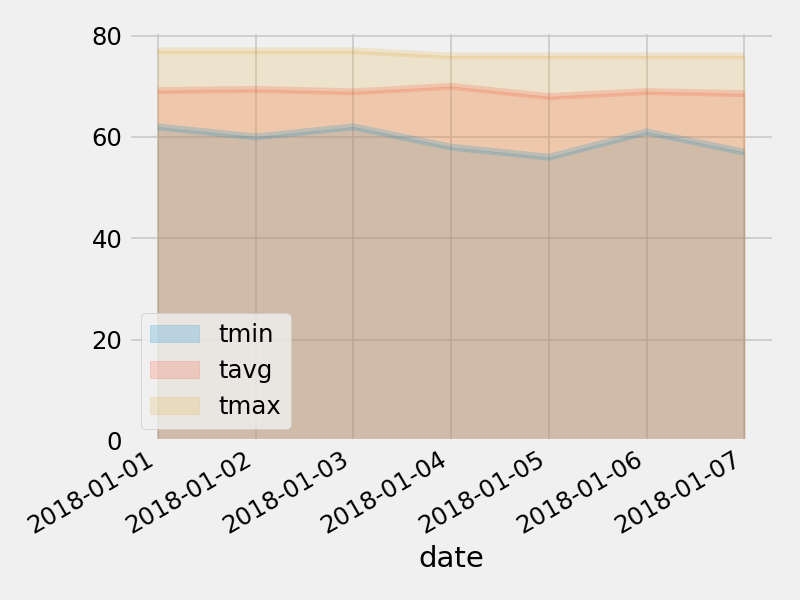

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
